In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('flight analyze').getOrCreate()

25/03/17 23:48:03 WARN Utils: Your hostname, deepak-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.31.105 instead (on interface wlp1s0)
25/03/17 23:48:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/17 23:48:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/17 23:48:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
flightData_2010 = spark.read.option('inferSchema', 'true').option('header', 'true').csv('/home/deepak/programs/python/SPARK/Spark-The-Definitive-Guide-master/data/flight-data/csv/2010-summary.csv')

# for infer schema spark peaked onlt few rows to determine the datatypes this approach is not recommened in production
# since we just mentioned the transformation so spark doesnt execute anything untill anction is called

In [4]:
flightData_2010

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: int]

In [5]:
flightData_2010.take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=264),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='India', count=69)]

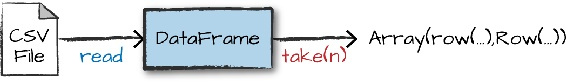

In [6]:
## Perform Sort transformation
# we can check the spark plan using explain 
flightData_2010.sort('count', ascending=False).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#19 DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(count#19 DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=33]
      +- FileScan csv [DEST_COUNTRY_NAME#17,ORIGIN_COUNTRY_NAME#18,count#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/deepak/programs/python/SPARK/Spark-The-Definitive-Guide-mas..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




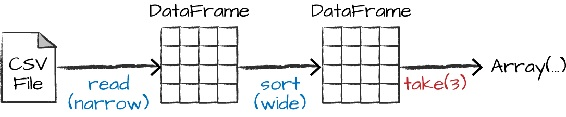

In [7]:
len(set(flightData_2010.select('count').collect()))

157

In [8]:
## The default shuffel partitions are 200 so lets make it 5 

# spark.conf.set('spark.sql.shuffle.partitions', '7')

In [9]:
flightData_2010.sort('count').take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=1),
 Row(DEST_COUNTRY_NAME='Equatorial Guinea', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='Malta', ORIGIN_COUNTRY_NAME='United States', count=1)]

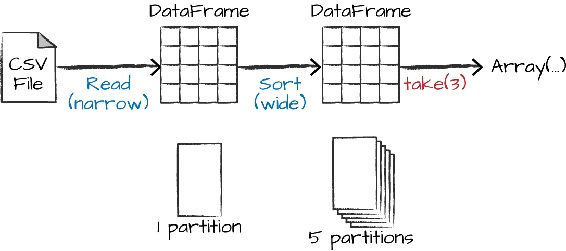

In [10]:
# you can always create a temporary table/view to perform sql query operations, there is no performance differnce between using datafram or sparksql 
# both results in same plan

flightData_2010.createOrReplaceTempView('flightdata_2010')

In [11]:
sql_way = spark.sql("""
select dest_country_name, count(*) from flightdata_2010
group by dest_country_name
""")

df_way = flightData_2010.groupBy('dest_country_name').count()

sql_way.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[dest_country_name#17], functions=[count(1)])
   +- Exchange hashpartitioning(dest_country_name#17, 200), ENSURE_REQUIREMENTS, [plan_id=58]
      +- HashAggregate(keys=[dest_country_name#17], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#17] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/deepak/programs/python/SPARK/Spark-The-Definitive-Guide-mas..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [12]:
df_way.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[dest_country_name#17], functions=[count(1)])
   +- Exchange hashpartitioning(dest_country_name#17, 200), ENSURE_REQUIREMENTS, [plan_id=71]
      +- HashAggregate(keys=[dest_country_name#17], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#17] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/deepak/programs/python/SPARK/Spark-The-Definitive-Guide-mas..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [13]:
## Notice that these plan compute to exact same plan

In [14]:
# using max function

from pyspark.sql.functions import max

max1 = spark.sql("""
select max(count) from flightdata_2010
""").take(1)

max2 = flightData_2010.select(max('count')).take(1)
max1, max2

([Row(max(count)=348113)], [Row(max(count)=348113)])

In [15]:
flightData_2010

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: int]

In [16]:
# find top 5 dest countries 

spark.sql("""
    select dest_country_name from flightdata_2010
    group by dest_country_name
    order by sum(count) desc 
    limit 5     
""").collect()

[Row(dest_country_name='United States'),
 Row(dest_country_name='Canada'),
 Row(dest_country_name='Mexico'),
 Row(dest_country_name='United Kingdom'),
 Row(dest_country_name='Germany')]

In [17]:
flightData_2010.groupBy('dest_country_name').sum('count').withColumnRenamed('sum(count)', 'destTotalCount').sort('destTotalCount', ascending=False).limit(5).show()

+-----------------+--------------+
|dest_country_name|destTotalCount|
+-----------------+--------------+
|    United States|        384932|
|           Canada|          8271|
|           Mexico|          6200|
|   United Kingdom|          1629|
|          Germany|          1392|
+-----------------+--------------+



In [18]:
flightData_2010.groupBy('dest_country_name').sum('count').withColumnRenamed('sum(count)', 'destTotalCount').sort('destTotalCount', ascending=False).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [destTotalCount#104L DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(destTotalCount#104L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=245]
      +- HashAggregate(keys=[dest_country_name#17], functions=[sum(count#19)])
         +- Exchange hashpartitioning(dest_country_name#17, 200), ENSURE_REQUIREMENTS, [plan_id=242]
            +- HashAggregate(keys=[dest_country_name#17], functions=[partial_sum(count#19)])
               +- FileScan csv [DEST_COUNTRY_NAME#17,count#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/deepak/programs/python/SPARK/Spark-The-Definitive-Guide-mas..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>




25/03/18 01:20:45 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 5208606 ms exceeds timeout 120000 ms
25/03/18 01:20:45 WARN SparkContext: Killing executors is not supported by current scheduler.
25/03/18 01:20:47 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

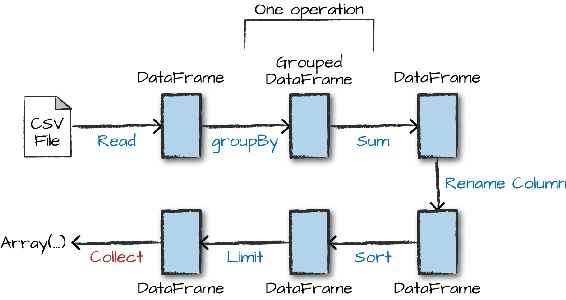

above is the DAG of transformation representing the flow